In [ ]:
!pip install scikit-learn

In [1]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image as image_loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import tensorflow as tf

Define hyper parameter

In [3]:
Image_Width = 260
Image_Height = 260
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3
Num_Class=2




Batch_Size = 40
lr=1e-2
loss_function = "categorical_crossentropy"
Epochs = 100

Define Paths

In [4]:
main_path = "datasets/misc/lspd/images/aliakbar"
train_path = main_path + "/train"
test_path = main_path + "/test"
validation_path = main_path + "/validation"
checkpoint_filepath = "check_point.h5"
tensorboard_log = "logs"
model_save_path = "."

Dataset Preparation

In [5]:
train_datagen = ImageDataGenerator(
                    rotation_range=10, # rotation
                    width_shift_range=0.2, # horizontal shift
                    height_shift_range=0.2, # vertical shift
                    zoom_range=0.2, # zoom
                    horizontal_flip=True, # horizontal flip
                    brightness_range=[0.2,1.2]
) 
train_generator = train_datagen.flow_from_directory(
                                                 directory=train_path,
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 color_mode="rgb",
                                                 batch_size=Batch_Size,
                                                 shuffle=True,
                                                 seed=2020 # to make the result reproducible
                                                   )
validation_datagen = ImageDataGenerator(
                    rotation_range=10, # rotation
                    width_shift_range=0.2, # horizontal shift
                    height_shift_range=0.2, # vertical shift
                    zoom_range=0.2, # zoom
                    horizontal_flip=True, # horizontal flip
                    brightness_range=[0.2,1.2]
) 
validation_generator = validation_datagen.flow_from_directory(
                                                 directory=validation_path,
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 color_mode="rgb",
                                                 batch_size=Batch_Size,
                                                 shuffle=True,
                                                 seed=2020 # to make the result reproducible
                                                )
test_datagen = ImageDataGenerator(
                    rotation_range=10, # rotation
                    width_shift_range=0.2, # horizontal shift
                    height_shift_range=0.2, # vertical shift
                    zoom_range=0.2, # zoom
                    horizontal_flip=True, # horizontal flip
                    brightness_range=[0.2,1.2]
) 


test_generator = test_datagen.flow_from_directory(
                    directory=test_path,
                    target_size=Image_Size, # resize to this size
                    color_mode="rgb", # for coloured images
                    batch_size=Batch_Size, # number of images to extract from folder for every batch
                    class_mode="categorical", # classes to predict
                    seed=2020, # to make the result reproducible
                    shuffle=True
                    )

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/misc/lspd/images/aliakbar/train'

Plot somr Datas

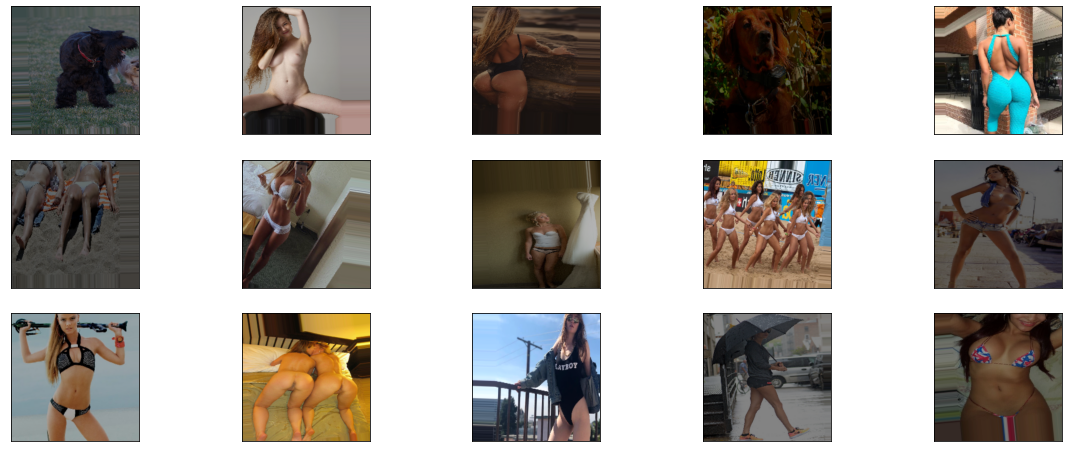

In [6]:
figure = plt.figure(figsize=(20, 8))
for i in range(15) :
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = next(train_generator)[0][-1].astype('uint8')
    ax.imshow(np.squeeze(image))
    

ReduceLROnPlateau = https://keras.io/api/callbacks/reduce_lr_on_plateau/ -> reduce lr when no improvment
EarlyStopping     = https://keras.io/api/callbacks/early_stopping/       -> stop training if no improvment
ModelCheckpoint   = https://keras.io/api/callbacks/model_checkpoint/     -> save checkpoint
TensorBoard       = https://keras.io/api/callbacks/tensorboard/          -> tensorboard

In [7]:
earlystop               = EarlyStopping(patience=10)
tensorboard             = TensorBoard(log_dir=tensorboard_log,histogram_freq=1,update_freq='batch',profile_batch=True ,write_graph=True,write_images=True,write_steps_per_second=True)
checkpoint              = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
callbacks               = [earlystop, learning_rate_reduction,checkpoint,tensorboard]

2022-04-13 17:06:45.879614: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-04-13 17:06:45.879637: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-04-13 17:06:45.916850: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2022-04-13 17:06:45.934666: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-04-13 17:06:45.934724: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed


Build Model

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
import tensorflow as tf
def model_builder():
    inputs = layers.Input(shape=(Image_Width, Image_Height, Image_Channels))
    model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(Num_Class, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy","MeanSquaredError","AUC"]
    )
    return model
model = model_builder()

2022-04-13 17:06:45.955493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:06:45.988859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:06:45.990029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:06:45.991318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Start Training

In [ ]:

history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // Batch_Size,
    steps_per_epoch=train_generator.samples // Batch_Size,
    callbacks=callbacks
)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2022-04-13 17:06:49.071083: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-04-13 17:06:49.071107: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.


Epoch 1/100


2022-04-13 17:06:56.924315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-04-13 17:07:00.980957: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-04-13 17:07:00.988515: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1764] CUPTI activity buffer flushed
2022-04-13 17:07:01.065718: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 18991 callback api events and 15978 activity events. 
2022-04-13 17:07:01.234472: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-04-13 17:07:01.552755: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_04_13_17_07_01

2022-04-13 17:07:01.825941: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.trace.json.gz
2022-04-13 17:07:02.01971

   1/1925 [..............................] - ETA: 6:56:58 - loss: 1.4302 - accuracy: 0.4000 - mean_squared_error: 0.4277 - auc: 0.4019

2022-04-13 17:07:02.029013: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.memory_profile.json.gz
2022-04-13 17:07:02.033632: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/plugins/profile/2022_04_13_17_07_01
Dumped tool data for xplane.pb to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.xplane.pb
Dumped tool data for overview_page.pb to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to logs/plugins/profile/2022_04_13_17_07_01/60450f7e85d6.kernel_stats.pb



1925/1925 [==============================] - 1488s 767ms/step - loss: 0.7794 - accuracy: 0.7184 - mean_squared_error: 0.2029 - auc: 0.7567 - val_loss: 2.2737 - val_accuracy: 0.6762 - val_mean_squared_error: 0.2644 - val_auc: 0.7024 - lr: 0.0100
Epoch 2/100
1206/1925 [=================>............] - ETA: 7:58 - loss: 0.5172 - accuracy: 0.7555 - mean_squared_error: 0.1664 - auc: 0.8338

In [6]:
from keras.models import load_model
model = load_model('check_point_last.h5')

2022-07-15 10:04:35.670748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.711085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.712358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.714210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Save Models

In [7]:
now = datetime.now()
 
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print(model_save_path+'/'+dt_string+'.h5')
model.save(model_save_path+'/'+dt_string+'.h5')

./15-07-2022_10-04-39.h5


In [26]:
test_path = "../datasets/storage_disk/h/labled_data/train"

Predict For check data

In [29]:
len(images_path)

399632

In [28]:
folders = os.listdir(test_path)
images_path = []
for folder in folders :
    for image in os.listdir(test_path+'/'+folder):
        path = test_path+'/'+folder+'/'+image
        images_path.append(path)
        

In [30]:
def image_predict(image_path):
    
    img = image_loader.load_img(image_path,target_size=(224,224))
    img_tensor = image_loader.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)   
    return img_tensor


In [31]:
random.shuffle(images_path)
labels =train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i,img_path in enumerate( images_path[0:15]):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = image_loader.load_img(img_path, target_size=Image_Size)
    ax.imshow(np.squeeze(image))
    image_to_predict = image_predict(img_path)
    predict = np.argmax(model.predict(image_to_predict))
    true_label = "porn" if '/p_' in img_path else "normal"
    ax.set_title("predict :{} ({})".format(labels[predict], 
                                  true_label),
                                  color=("green" if true_label == labels[predict] else "red"))

NameError: name 'train_generator' is not defined

In [ ]:
from keras.models import load_model
del model
model = load_model('25_03_2022.22_11_26.h5')

In [ ]:
y_pred = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
y_test = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2])

In [1]:
labels = {
    0:'porn',
    1:'normal'
}
y_pred = []
y_test = []

labels = dict((v, k) for k, v in labels.items())
for folder in os.listdir("../datasets/storage_disk/h/labled_data/train"):
    items = os.listdir("../datasets/storage_disk/h/labled_data/train/"+folder)
    random.shuffle(items)
    counter = 0
    for item in items:
            image_to_predict = image_predict("../datasets/storage_disk/h/labled_data/train/"+folder+"/"+item)
            predict = np.argmax(model.predict(image_to_predict))
            real_id = 0 if folder=='normal' else 1
            y_pred.append(predict)
            y_test.append(real_id)


NameError: name 'os' is not defined

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()